# Creating labels for training/testing toxicity detector classifier models.

### John Burt


### Introduction:

This notebook reads the comment data and creates integer training label variables for training models. 



In [22]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np
import datetime
import time
import csv
import glob


# source data folder 
srcdir = './data_labeled/'

# the subreddits I'll be analyzing
sub2use = ['aww', 'funny', 'todayilearned','askreddit',
           'photography', 'gaming', 'videos', 'science',
           'politics', 'politicaldiscussion',             
           'conservative', 'the_Donald']

# load all labelled CSVs
dfs = []
for subname in sub2use:
    pathname = srcdir+'comment_sample_'+subname+'_labeled.csv'
#     print('reading',pathname)
    tdf = pd.read_csv(pathname)
    dfs.append(tdf)

# combine all subreddit datasets into one  
df = pd.concat(dfs).drop_duplicates()

# remove any deleted or removed comments 
df = df[(df.text!='[deleted]') & (df.text!='[removed]')]

# drop samples with NaNs
df.dropna(inplace=True)

# drop duplicates
df = df.drop_duplicates(subset='comment_ID')

# reformat parent ids to match comment ids
df.parent_ID = df.parent_ID.str.replace('t1_','')
df.parent_ID = df.parent_ID.str.replace('t3_','')

print('\nTotal comment samples read:',df.shape[0])


Total comment samples read: 3251323


## Create training labels

Using the PCA score data generated earlier, I'll create three different training label schemes:

- five integer levels ranging from -2 to +2. This preserves the range of scores, from high positive to low negative scores.

- five integer levels ranging from 0-4, inverted so that higher values indicate more toxicity. Any sample with PCA score >= 0 will be labelled 0.

- 0/1 binary value, with 1 = toxic, and 0 = non-toxic. To determine the threshold.

# > 0 (low toxicity) = 402908 # <= 0 (higher toxicity) = 2848415


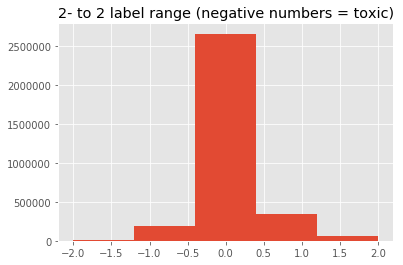

In [27]:
# five integer levels ranging from -2 to +2.
df['label_neg-pos'] = (df['pca_score'] / 2).round()
df['label_neg-pos'].hist(bins=5);

plt.title('2- to 2 label range (negative numbers = toxic)');

print('# > 0 (low toxicity) =',(df['label_neg-pos']>0).sum(),
      '# <= 0 (higher toxicity) =',(df['label_neg-pos']<=0).sum())

# = 0 (low toxicity) = 2209704 # > 0 (higher toxicity) = 1041619


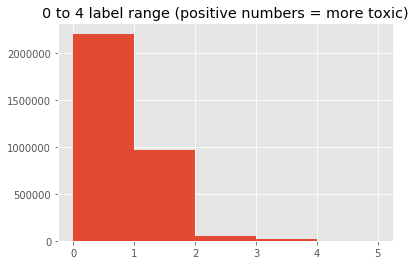

In [28]:
# five integer levels ranging from 0-4, inverted so that higher values indicate more toxicity. 
#  Any sample with PCA score >= 0 will be labelled 0.
df['label_neg-inv'] = -(df['pca_score']).round()
df['label_neg-inv'][df['label_neg-inv']<0] = 0
df['label_neg-inv'].hist(bins=5);
plt.title('0 to 4 label range (positive numbers = more toxic)');

print('# = 0 (low toxicity) =',(df['label_neg-inv']==0).sum(),
      '# > 0 (higher toxicity) =',(df['label_neg-inv']>0).sum())

In [30]:
# 0/1 binary value, with 1 = toxic, and 0 = non-toxic. To determine the threshold.

threshold = -2

df['label_bin'] = (df['pca_score'] < threshold).astype(int)

print('#above thresh (low toxicity) =',(df['label_bin']==0).sum(),
      '#below thresh (higher toxicity) =',(df['label_bin']==1).sum())

#above thresh (low toxicity) = 3212854 #below thresh (higher toxicity) = 38469


In [26]:
outpath = srcdir+'comment_sample_traintest_data.csv'
df.to_csv(outpath,index=False)
print('saved reply data to',outpath)

saved reply data to ./data_labeled/comment_sample_traintest_data.csv
